In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

**Solving Sudoku with Neural Network Models- Part 2**

Sudoku is a number puzzle game that requires you to fill in digits 1 to 9. The game requires digits 1 to 9 to appear exactly once in each row, column and each of the nine 3x3 subgrids. The project experiment with different neural networks such as CNN. The data have been divided by 9 and subtracted by 0.5 to achieve zero mean-centred data.

In [21]:
import numpy as np
import pandas as pd
from tqdm import tqdm

**Data Preprocessing**

In [22]:
import pandas as pd
import numpy as np

def get_data(file):
    data = pd.read_csv(file)

    feat_raw = data['quizzes']
    label_raw = data['solutions']

    feat = []
    label = []
    
    print("Loading Sudokus")
    for i in feat_raw:
        x = np.array([int(j) for j in i]).reshape((1,9,9))
        feat.append(x)

    feat = np.array(feat)
    feat = feat/9 - 0.5
    
    print("Loading Solutions")
    for i in label_raw:
        x = np.array([int(j) for j in i]).reshape((9,9)) - 1
        label.append(x)

    label = np.array(label)
    
    # Manually split the dataset into training and testing sets
    split_index = int(len(feat) * 0.8)
    x_train, x_test = feat[:split_index], feat[split_index:]
    y_train, y_test = label[:split_index], label[split_index:]

    return x_train, x_test, y_train, y_test


In [24]:
from torch.utils.data import Dataset
import numpy as np
class DatasetInstance(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X :sudoku, y: solutions

        """
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self,index):

        sudoku = self.X[index]
        target = self.y[index]
        return sudoku,target

In [25]:
x_train, x_test, y_train, y_test = get_data("/kaggle/input/mytrain/s2annimp.csv")
#convert to tensors
X_train = torch.tensor(x_train).type(torch.FloatTensor)
X_test = torch.tensor(x_test).type(torch.FloatTensor)
y_train = torch.tensor(y_train).type(torch.LongTensor)
y_test = torch.tensor(y_test).type(torch.LongTensor)

train_dataset = DatasetInstance(X_train, y_train)
test_dataset = DatasetInstance(X_test, y_test)
# load training data in batches
batch_size = 640
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
# load test data in batches
batch_size =640

val_loader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=False)

Loading Sudokus
Loading Solutions


**Model Implementation**

In [27]:
class Conv2dSame(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=True, padding_layer=torch.nn.ReflectionPad2d):
        """It only support square kernels and stride=1, dilation=1, groups=1."""
        super(Conv2dSame, self).__init__()
        ka = kernel_size // 2
        kb = ka - 1 if kernel_size % 2 == 0 else ka
        self.net = nn.Sequential(
            padding_layer((ka,kb,ka,kb)),
            nn.Conv2d(in_channels, out_channels, kernel_size, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
    def forward(self, x):
        return self.net(x)
class SudokuCNN(nn.Module):
    def __init__(self):
        super(SudokuCNN, self).__init__()
        self.conv_layers = nn.Sequential(Conv2dSame(1,512,3), #1
                                         Conv2dSame(512,512,3),#2
                                         Conv2dSame(512,512,3),#3
                                         Conv2dSame(512,512,3),#4
        )

        self.last_conv = nn.Conv2d(512, 9, 1)
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.last_conv(x)
        return x.view(-1,9)


**Training and Testing**

Epoch 1/10: Train Loss: 1.4383, Train Accuracy: 39.5348, Validation Loss: 1.7809, Validation Accuracy: 29.5427
Epoch 2/10: Train Loss: 1.3759, Train Accuracy: 41.5207, Validation Loss: 1.7989, Validation Accuracy: 29.6431
Epoch 3/10: Train Loss: 1.3400, Train Accuracy: 42.6371, Validation Loss: 1.8185, Validation Accuracy: 29.6118
Epoch 4/10: Train Loss: 1.3042, Train Accuracy: 43.7485, Validation Loss: 1.8444, Validation Accuracy: 29.6866
Epoch 5/10: Train Loss: 1.2679, Train Accuracy: 44.8798, Validation Loss: 1.8584, Validation Accuracy: 29.6712
Epoch 6/10: Train Loss: 1.2319, Train Accuracy: 45.9813, Validation Loss: 1.8944, Validation Accuracy: 29.5706
Epoch 7/10: Train Loss: 1.1966, Train Accuracy: 47.0596, Validation Loss: 1.9202, Validation Accuracy: 29.6943
Epoch 8/10: Train Loss: 1.1618, Train Accuracy: 48.1112, Validation Loss: 1.9489, Validation Accuracy: 29.5847
Epoch 9/10: Train Loss: 1.1270, Train Accuracy: 49.1594, Validation Loss: 1.9919, Validation Accuracy: 29.4362
E

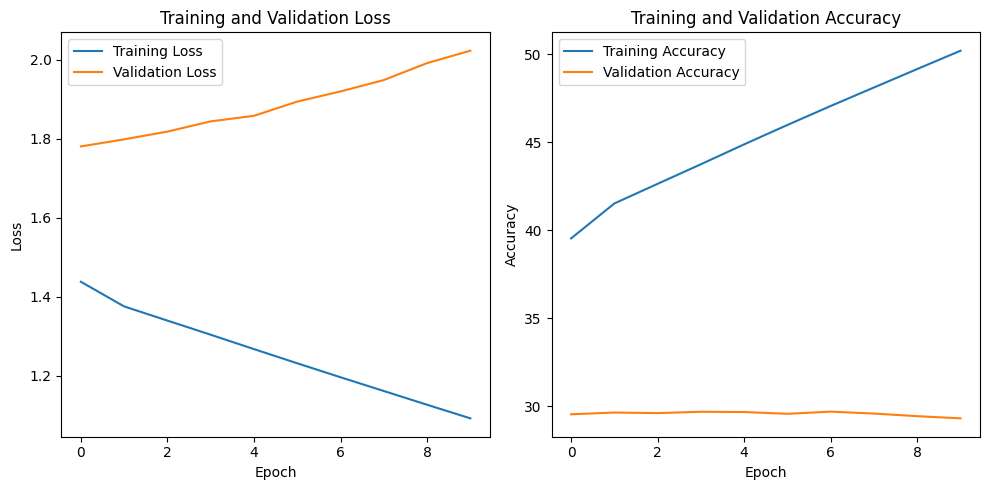

In [28]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim  # Add this line for optim module
import matplotlib.pyplot as plt

# Define the training function
def train_model(model, train_loader, val_loader, epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for puzzles, solutions in train_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)
            optimizer.zero_grad()
            outputs = model(puzzles)
            loss = criterion(outputs, solutions.view(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += solutions.size(0)
            correct_train += (predicted == solutions.view(-1)).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for puzzles, solutions in val_loader:
                puzzles, solutions = puzzles.to(device), solutions.to(device)
                outputs = model(puzzles)
                val_loss += criterion(outputs, solutions.view(-1)).item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += solutions.size(0)
                correct_val += (predicted == solutions.view(-1)).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{epochs}: '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, epochs=10, device=device)

# Plotting
plt.figure(figsize=(10, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


From this, we can understand that the validation loss is keeps on inceasing.